In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# ------------------------------------------------------------------------------
#
#   Copyright 2024 Valory AG
#
#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.
#
# ------------------------------------------------------------------------------

"""Script for analyzing market creator markets."""

from collections import defaultdict
from datetime import datetime, timedelta
from enum import Enum
from mech_request_utils import get_mech_requests, IPFS_ADDRESS
from scipy import stats
from string import Template
from typing import Any, Dict, Optional

import dateutil.parser
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import requests

MARKET_CREATOR_ADDRESS = "0x89c5cc945dd550BcFfb72Fe42BfF002429F46Fec"

## Process mech requests
Process mech requests from the Market Creator

In [2]:
mech_requests = get_mech_requests(MARKET_CREATOR_ADDRESS)

          Fetching requests...


    Finding duplicate delivers: 100%|██████████| 1363/1363 [00:00<00:00, 1359533.02it/s]


Duplicate deliver ids found: 15


    Finding duplicate delivers: 100%|██████████| 1363/1363 [00:00<00:00, 1451710.60it/s]


Duplicate deliver ids found: 0


        Fetching IPFS contents: 100%|██████████| 1363/1363 [00:05<00:00, 264.69it/s] 


DescribeResult(nobs=1336, minmax=(4, 42851), mean=259.9258982035928, variance=3505306.27989807, skewness=18.127467913454023, kurtosis=396.0303681133452)


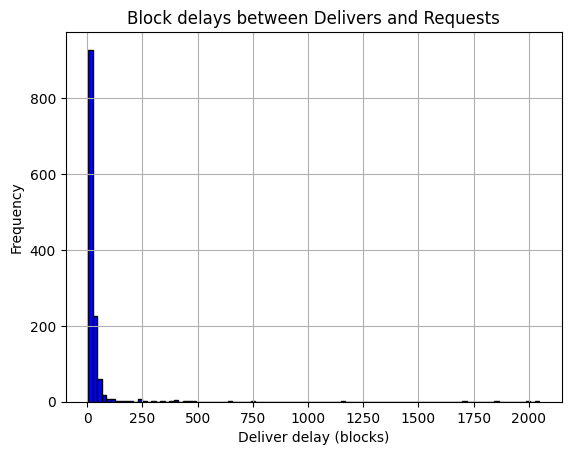

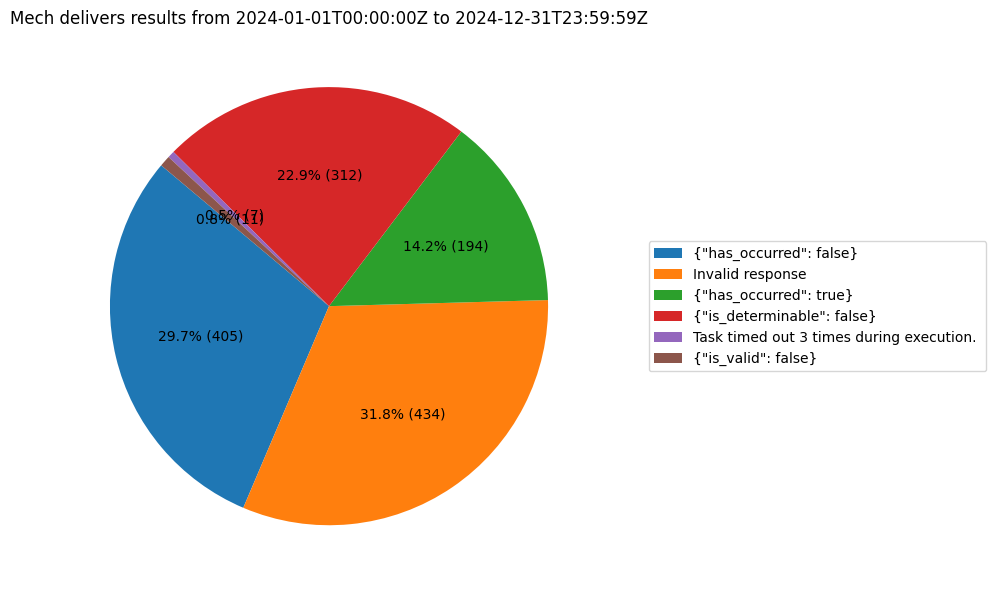

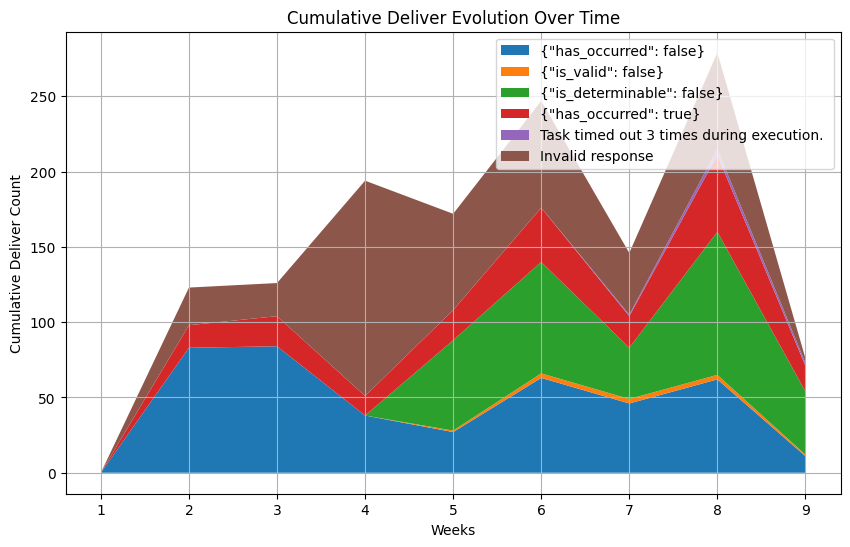

In [8]:
class MechDeliverState(Enum):
    """Market state"""

    INVALID_RESPONSE = 1
    TIMEOUT = 2
    RESPONSE_NOT_DETERMINABLE = 3
    RESPONSE_INVALID_MARKET = 4
    RESPONSE_YES = 5
    RESPONSE_NO = 6
    UNKNOWN = 7
    NA = 8

    def __str__(self) -> str:
        """Prints the market status."""
        return self.name.lower()

# HISTOGRAM OF BLOCK DELAYS
deliver_delay_blocks = []
for request_data in mech_requests.values():
    if 'deliver' in request_data:
        request_block = int(request_data['blockNumber'])
        deliver_block = int(request_data['deliver']['blockNumber'])
        delay = deliver_block - request_block
        deliver_delay_blocks.append(delay)

deliver_delay_blocks_stats = stats.describe(deliver_delay_blocks)
print(deliver_delay_blocks_stats)

# Filter out outliers
mean = deliver_delay_blocks_stats[2]
std = np.sqrt(deliver_delay_blocks_stats[3])
alpha = 1
deliver_delay_blocks = [td for td in deliver_delay_blocks if np.abs(td - mean) <= alpha * std]

# Create histogram
plt.hist(deliver_delay_blocks, bins=100, color='blue', edgecolor='black')
plt.xlabel('Deliver delay (blocks)')
plt.ylabel('Frequency')
plt.title('Block delays between Delivers and Requests')
plt.grid(True)
plt.show()


# HISTOGRAM OF DELIVERS PER RESPONSE
def _count_delivers_type_per_response(mech_requests: Dict[str, Any], from_timestamp: int = 0, to_timestamp: int = 2147483647) -> None:
    result_counts = {}

    for request_data in mech_requests.values():
        block_timestamp = int(request_data.get('blockTimestamp', 0))
        if from_timestamp <= block_timestamp <= to_timestamp:
            if 'deliver' in request_data:
                result = request_data['deliver']['ipfsContents']['result']
                try:
                    result_json = json.loads(result)
                    first_item_key = list(result_json.keys())[0]
                    first_item_value = result_json[first_item_key]
                    result = json.dumps({first_item_key: first_item_value})
                    result_counts[result] = result_counts.get(result, 0) + 1
                except json.JSONDecodeError:
                    result_counts[result] = result_counts.get(result, 0) + 1
            else:
                result_counts[result] = result_counts.get(result, 0) + 1

    return result_counts


def plot_delivers_evolution_over_time(mech_requests: Dict[str, Any], from_timestamp: int, weeks: int = 1) -> None:
    all_result_counts = []

    for i in range(weeks):
        from_timestamp_week = from_timestamp + (i * 7 * 24 * 3600)  # Add i weeks
        to_timestamp_week = from_timestamp_week + (7 * 24 * 3600)  # One week later
        result_counts = _count_delivers_type_per_response(mech_requests, from_timestamp_week, to_timestamp_week)
        all_result_counts.append(result_counts)

    result_types = set().union(*(d.keys() for d in all_result_counts))
    result_counts_per_week = {result_type: [week_result_counts.get(result_type, 0) for week_result_counts in all_result_counts] for result_type in result_types}

    plt.figure(figsize=(10, 6))
    weeks_range = range(1, weeks + 1)
    cumulative_counts = [0] * weeks
    for result_type, counts_per_week in result_counts_per_week.items():
        plt.fill_between(weeks_range, cumulative_counts, [cumulative_count + current_count for cumulative_count, current_count in zip(cumulative_counts, counts_per_week)], label=result_type)
        cumulative_counts = [cumulative_count + current_count for cumulative_count, current_count in zip(cumulative_counts, counts_per_week)]

    plt.title('Cumulative Deliver Evolution Over Time')
    plt.xlabel('Weeks')
    plt.ylabel('Cumulative Deliver Count')
    plt.legend()
    plt.grid(True)
    plt.show()



from_date = "2024-01-01T00:00:00Z"
to_date = "2024-12-31T23:59:59Z"

from_timestamp = int(dateutil.parser.isoparse(from_date).replace(tzinfo=pytz.utc).timestamp())
to_timestamp = int(dateutil.parser.isoparse(to_date).replace(tzinfo=pytz.utc).timestamp())

result_counts = _count_delivers_type_per_response(mech_requests, from_timestamp, to_timestamp)

# Calculate total count
total_count = sum(result_counts.values())

# Separate result types and counts
result_types = list(result_counts.keys())
counts = list(result_counts.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.title(f'Mech delivers results from {from_date} to {to_date}')
plt.axis('equal')
plt.pie(counts, labels=None, autopct=lambda pct: f'{pct:.1f}% ({int(np.round(pct / 100. * total_count))})', startangle=140)
plt.legend(result_types, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


from_date = "2024-02-19T00:00:00Z"
from_timestamp = int(dateutil.parser.isoparse(from_date).replace(tzinfo=pytz.utc).timestamp())

plot_delivers_evolution_over_time(mech_requests, from_timestamp, weeks=9)  # Plot evolution for 4 weeks


## Process Omen markets
Process Omen markets by reading from the Omen xDAI Subgraph

In [4]:
class MarketState(Enum):
    """Market state"""

    OPEN = 1
    PENDING = 2
    FINALIZING = 3
    ARBITRATING = 4
    CLOSED = 5
    UNKNOWN = 6

    def __str__(self) -> str:
        """Prints the market status."""
        return self.name.capitalize()


answer_mapping = defaultdict(
    lambda: "Unknown",
    {
        "0x0000000000000000000000000000000000000000000000000000000000000000": "Yes",
        "0x0000000000000000000000000000000000000000000000000000000000000001": "No",
        "0xffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff": "Invalid",
    },
)

headers = {
    "Accept": "application/json, multipart/mixed",
    "Content-Type": "application/json",
}

omen_xdai_fpmms_query = Template(
    """
    {
      fixedProductMarketMakers(
        where: {
          creator: "0x89c5cc945dd550bcffb72fe42bff002429f46fec",
          creationTimestamp_gt: "${creationTimestamp_gt}"
        }
        orderBy: creationTimestamp
        orderDirection: asc
        first: 1000
      ) {
        question {
          title
          outcomes
          currentAnswer
          currentAnswerTimestamp
          answers {
            answer
          }
        }
        id
        openingTimestamp
        resolutionTimestamp
        creationTimestamp
        isPendingArbitration
        answerFinalizedTimestamp
        currentAnswer
        collateralVolume
      }
    }
    """
)


def _get_date(timestamp: float) -> str:
    try:
        timestamp = int(timestamp)
        return datetime.utcfromtimestamp(timestamp).isoformat()
    except Exception:  # pylint: disable=broad-except
        return "--"


def _get_market_state(market: Dict[str, Any]) -> MarketState:
    try:
        now = datetime.utcnow()

        market_status = MarketState.CLOSED
        if market["currentAnswer"] is None and now >= datetime.utcfromtimestamp(float(market.get("openingTimestamp", 0))):
            market_status = MarketState.PENDING
        elif market["currentAnswer"] is None:
            market_status = MarketState.OPEN
        elif market["isPendingArbitration"]:
            market_status = MarketState.ARBITRATING
        elif now < datetime.utcfromtimestamp(float(market.get("answerFinalizedTimestamp", 0))):
            market_status = MarketState.FINALIZING

        return market_status
    except Exception:  # pylint: disable=broad-except
        return MarketState.UNKNOWN


def _get_remaining_resolution_time(market: Dict[str, Any]) -> str:
    if market["answerFinalizedTimestamp"]:
        now = datetime.utcnow()

        finalized_time = datetime.utcfromtimestamp(
            float(market["answerFinalizedTimestamp"])
        )
        time_diff = finalized_time - now

        if time_diff >= timedelta(0):
            hours = int(time_diff.total_seconds() // 3600)
            minutes = int((time_diff.total_seconds() % 3600) // 60)
            return "{:02d}:{:02d}".format(hours, minutes)
    return "--"


def _get_market_title(market: Dict[str, Any]) -> str:
    question_title = "question_title"
    url = ""
    if market.get("question"):
        question_title = market["question"].get("title", "")
        url = f'https://aiomen.eth.limo/#/{market.get("id","")}'
    return _make_clickable(question_title, url)


def _get_collateral_volume(market: Dict[str, Any]) -> str:
    volume = int(market.get("collateralVolume", 0))
    formatted_volume = f"{volume / 10**18:.2f}"
    return formatted_volume

def _get_current_answer(market: Dict[str, Any]) -> str:
    currentAnswer = market.get("currentAnswer", "")
    if not currentAnswer:
        currentAnswer = ""
    return answer_mapping.get(currentAnswer.lower(), "--")


def _get_num_answers(market: Dict[str, Any]) -> int:
    question = market.get("question", {})
    if not question:
        question = {}
    return len(question.get("answers", []))


def _execute_fpmm_query() -> Dict[str, Any]:
    url = "https://api.thegraph.com/subgraphs/name/protofire/omen-xdai"

    all_markets = []
    creationTimestamp_gt = "0"

    while True:
        query = omen_xdai_fpmms_query.substitute(
            creationTimestamp_gt=creationTimestamp_gt,
        )
        content_json = {
            "query": query,
            "variables": None,
            "extensions": {"headers": None},
        }
        res = requests.post(url, headers=headers, json=content_json, timeout=300)
        result_json = res.json()
        markets = result_json.get("data", {}).get("fixedProductMarketMakers", [])

        if not markets:
            break

        all_markets.extend(markets)
        creationTimestamp_gt = markets[len(markets) - 1]["creationTimestamp"]

    output = {"data": {"fixedProductMarketMakers": all_markets}}
    return output

def _make_clickable(text: str, url: str) -> str:
    return f'<a href="{url}" target="_blank">{text}</a>'



In [5]:
def _populate_with_mech_requests(data: Dict[str, Any], mech_requests: Dict[str, Any]) -> None:
    """Populates the markets by appending an array of the associated mech requests"""
    markets = data["data"]["fixedProductMarketMakers"]
    markets_dict = {market["question"].get("title", ""): market for market in markets if market.get("question")}

    for mech_request in mech_requests.values():
        if "ipfsContents" in mech_request:
            q = mech_request["ipfsContents"]["prompt"]
            if q in markets_dict:
                markets_dict[q].setdefault("mechRequests", []).append(mech_request)
            else:
                print("Market not found for mech request: {mech_request}")
    
    for market in markets:
        market.setdefault("mechRequests", []).sort(key=lambda x: x.get("blockNumber", 0), reverse=True)

def _get_last_mech_deliver_link(market: Dict[str, Any], latest: Optional[int]=None) -> str:
    if market["mechRequests"]:
        output = ""
        n = len(market["mechRequests"])
        if not latest:
            latest = n
        for i in range(min(latest, n)):
            request = market["mechRequests"][i]
            if "deliver" in request:
                deliver = request["deliver"]
                ipfs_hash = deliver.get("ipfsHash", "")
                request_id = deliver.get("requestId", "")
                url = f"{IPFS_ADDRESS}{ipfs_hash}/{request_id}"
                output += _make_clickable(f"[{n-i}]", url)
            else:
                output += "[X]"
            output += " "
        
        return output
    
    return "-"

def _get_num_mech_requests(market: Dict[str, Any]) -> int:
    if market["mechRequests"]:
        return len(market["mechRequests"])
    return 0


def _get_last_mech_deliver_state(market: Dict[str, Any]) -> str:
    if not market["mechRequests"]:
        return MechDeliverState.NA

    request = market["mechRequests"][0]
    if "deliver" not in request:
        return  MechDeliverState.UNKNOWN

    result = request["deliver"]["ipfsContents"]["result"]
    
    if result == "Invalid response":
        return MechDeliverState.INVALID_RESPONSE
    if result.startswith("Task timed out"):
        return MechDeliverState.TIMEOUT

    result = result.replace(" ", "")
    if result == "{\"is_determinable\":false}":
        return MechDeliverState.RESPONSE_NOT_DETERMINABLE
    if result == "{\"has_occurred\":false}":
        return MechDeliverState.RESPONSE_NO
    if result == "{\"has_occurred\":true}":
        return MechDeliverState.RESPONSE_YES
    if result.startswith("{\"is_valid\":false"):
        return MechDeliverState.RESPONSE_INVALID_MARKET

    return MechDeliverState.UNKNOWN


def _generate_markets_df() -> pd.DataFrame:
    data = _execute_fpmm_query()
    _populate_with_mech_requests(data, mech_requests)
    rows = []
    for entry in data["data"]["fixedProductMarketMakers"]:
        rows.append(
            {
                "Title": _get_market_title(entry),
                "Volume (xDAI):": _get_collateral_volume(entry),
                "Current answer": _get_current_answer(entry),
                "Num answers": _get_num_answers(entry),
                "State": _get_market_state(entry),
                "Remaining time to challenge (hh:mm)": _get_remaining_resolution_time(entry),
                "Creation (UTC)": _get_date(entry["creationTimestamp"]),
                "Opening (UTC)": _get_date(entry["openingTimestamp"]),
                "Answer finalized (UTC)": _get_date(entry["answerFinalizedTimestamp"]),
                "Resolution (UTC)": _get_date(entry["resolutionTimestamp"]),
                "Num. mech requests": _get_num_mech_requests(entry),
                "Mech delivers": _get_last_mech_deliver_link(entry),
                "Mech deliver state": _get_last_mech_deliver_state(entry)
            }
        )

    df = pd.DataFrame(rows)
    df['State'] = df['State'].astype('category')
    df['Mech deliver state'] = df['Mech deliver state'].astype('category')
    df.sort_values(by="Creation (UTC)", ascending=False, inplace=True)
    return df

df = _generate_markets_df()
df.style.set_properties(subset=["Title"], **{'text-align': 'right'})
print(df.dtypes)

Title                                    object
Volume (xDAI):                           object
Current answer                           object
Num answers                               int64
State                                  category
Remaining time to challenge (hh:mm)      object
Creation (UTC)                           object
Opening (UTC)                            object
Answer finalized (UTC)                   object
Resolution (UTC)                         object
Num. mech requests                        int64
Mech delivers                            object
Mech deliver state                     category
dtype: object


Market state counts:
State
Closed        3047
Pending         95
Open            63
Finalizing      14
Unknown          1
Name: count, dtype: int64

Mech requests per state:
State
Unknown          0
Closed        1095
Open             0
Pending        221
Finalizing      47
Name: Num. mech requests, dtype: int64


/tmp/ipykernel_727198/1653459585.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('State')['Num. mech requests'].sum())


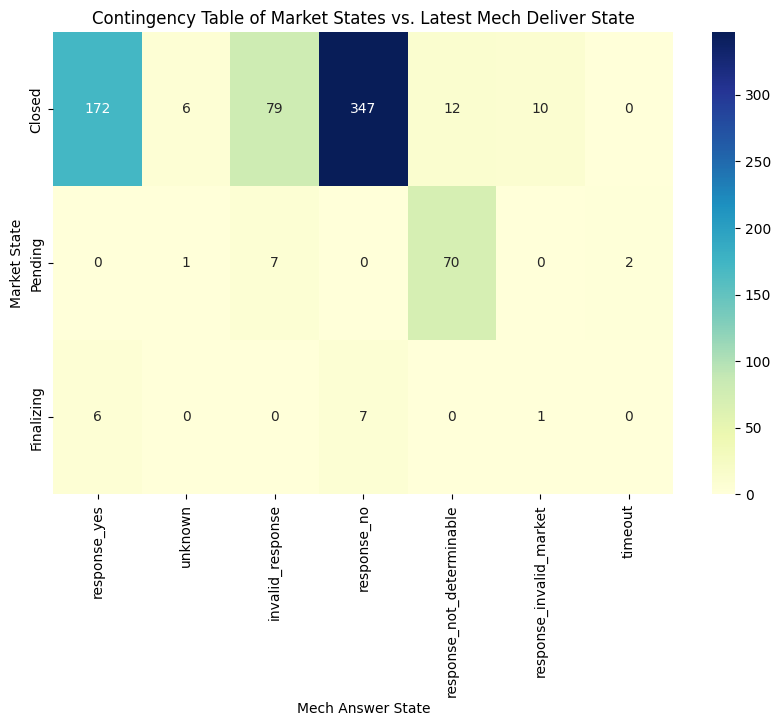

Filtering [<MarketState.PENDING: 2>, <MarketState.FINALIZING: 3>, <MarketState.UNKNOWN: 6>] markets


,Title,Volume (xDAI):,Current answer,Num answers,State,Remaining time to challenge (hh:mm),Creation (UTC),Opening (UTC),Answer finalized (UTC),Resolution (UTC),Num. mech requests,Mech delivers,Mech deliver state
3158,Will the Norfolk Southern payout of $600M for the toxic East Palestine Disaster be completed on or by 16 April 2024?,8.11,--,0,Pending,--,2024-04-12T04:05:20,2024-04-17T00:00:00,--,--,0,-,na
3157,Will the total solar eclipse happen across North America on 16 April 2024?,11.49,--,0,Pending,--,2024-04-12T03:53:40,2024-04-17T00:00:00,--,--,0,-,na
3156,Will the LIV golfer Joaquin Niemann achieve unified rankings by 16 April 2024?,6.98,--,0,Pending,--,2024-04-12T03:42:00,2024-04-17T00:00:00,--,--,0,-,na
3155,Will Louisiana pass a bill similar to Texas' migrant arrest law by 16 April 2024?,3.65,--,0,Pending,--,2024-04-12T03:30:15,2024-04-17T00:00:00,--,--,0,-,na
3154,Will the inflation increase more than 3.5% by 16 April 2024?,4.55,--,0,Pending,--,2024-04-12T03:18:30,2024-04-17T00:00:00,--,--,0,-,na
3153,Will the power line problems due to the Colorado windstorm be resolved by 16 April 2024?,6.95,--,0,Pending,--,2024-04-12T03:06:50,2024-04-17T00:00:00,--,--,0,-,na
3152,Will the iPhone 16 be released in 2024?,6.66,--,0,Pending,--,2024-04-12T02:53:30,2024-04-17T00:00:00,--,--,0,-,na
3151,Will the Palestinian flag emoji controversy involving Apple be resolved by 16 April 2024?,7.33,--,0,Pending,--,2024-04-12T02:41:50,2024-04-17T00:00:00,--,--,0,-,na
3150,Will OpenAI release GPT-4 by 16 April 2024?,12.80,--,0,Pending,--,2024-04-12T02:30:05,2024-04-17T00:00:00,--,--,0,-,na
3149,"Will the Samsung Galaxy Z Fold 6 come with the same camera hardware as its predecessor, the Galaxy Z Fold 5, by 16 April 2024?",6.03,--,0,Pending,--,2024-04-12T02:18:15,2024-04-17T00:00:00,--,--,0,-,na


In [6]:

from IPython.display import display, HTML
import seaborn as sns

print("Market state counts:")
print(df['State'].value_counts())

print("\nMech requests per state:")
print(df.groupby('State')['Num. mech requests'].sum())



filtered_df = df[df['Mech deliver state'] != MechDeliverState.NA]

# Generate the contingency table
contingency_table = pd.crosstab(filtered_df['State'], filtered_df['Mech deliver state'])

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Contingency Table of Market States vs. Latest Mech Deliver State')
plt.xlabel('Mech Answer State')
plt.ylabel('Market State')
plt.show()




# Select markets to display
market_states = [
    #MarketState.OPEN,
    MarketState.PENDING,
    MarketState.FINALIZING,
    #MarketState.ARBITRATING,
    #MarketState.CLOSED,
    MarketState.UNKNOWN
]

print(f"Filtering {market_states} markets")
df_filtered = df[df["State"].isin(market_states)]
pd.options.display.max_colwidth = 150
html = df_filtered.to_html(escape=False, classes='sortable')
display(HTML(df_filtered.to_html(escape=False)))